In [27]:
from embedding import *
import torch, numpy as np

data_embedding = generate_embedding_based_data(N=1000, D=20, T=20, K=5, P=5, embedding_dim=32)
Y_tensor = torch.tensor(data_embedding['Y'], dtype=torch.float32)
G_tensor = torch.tensor(data_embedding['G'], dtype=torch.float32)
prevalence_prob = torch.tensor(data_embedding['logit_prev_t'], dtype=torch.float32)  # this is logit; model converts to prob internally
E_tensor = event_times = torch.tensor(data_embedding['event_times'], dtype=torch.float32)

Debug - signature_refs shape: (5, 50)
Debug - logit_prev_t shape: (20, 50)
Debug - gamma shape: (5, 5)
Debug - psi shape: (5, 20)
Debug - T: 20, D: 20, K: 5


In [33]:
import torch

# Clean true_psi
true_psi = torch.as_tensor(data_embedding['psi'], dtype=torch.float32)
true_psi = torch.nan_to_num(true_psi, nan=0.0, posinf=4.0, neginf=-4.0)
true_psi = torch.clamp(true_psi, -4.0, 4.0)

# Clean Y (just in case)
Y_tensor = torch.nan_to_num(Y_tensor, nan=0.0, posinf=1.0, neginf=0.0)
Y_tensor = torch.clamp(Y_tensor, 0.0, 1.0)
K=5
T=50

# Create simple signature references
signature_refs = np.zeros((K, T))
for k in range(K):
    signature_refs[k, :] = np.linspace(0.5, 1.0, T)  # Simple increasing pattern

model = HierarchicalEmbeddingModel(
    N=Y_tensor.shape[0], D=Y_tensor.shape[1], T=Y_tensor.shape[2],
    K=data_embedding['phi'].shape[0], P=G_tensor.shape[1],
    G=G_tensor, Y=Y_tensor, R=0, W=0.0001,
    prevalence_t=prevalence_prob,
    init_sd_scaler=0.01, genetic_scale=1.0, embedding_dim=32,
    true_psi=torch.as_tensor(data_embedding['psi'], dtype=torch.float32),
    signature_references=signature_refs
)



In [34]:
# Debug the loss components
with torch.no_grad():
    pi, theta, phi_prob = model.forward()
    print("pi finite?", torch.isfinite(pi).all().item())
    
    # Check GP loss components
    learned_psi = model.compute_psi()
    print("learned_psi finite?", torch.isfinite(learned_psi).all().item())
    print("learned_psi range:", float(learned_psi.min()), float(learned_psi.max()))
    
    # Check kernel matrices
    print("K_lambda_init finite?", torch.isfinite(model.K_lambda_init).all().item())
    print("K_phi_init finite?", torch.isfinite(model.K_phi_init).all().item())
    
    # Check Cholesky decomposition
    try:
        L_lambda = torch.linalg.cholesky(model.K_lambda_init)
        print("Lambda Cholesky OK")
    except:
        print("Lambda Cholesky FAILED")
    
    try:
        L_phi = torch.linalg.cholesky(model.K_phi_init)
        print("Phi Cholesky OK")
    except:
        print("Phi Cholesky FAILED")

pi finite? True
learned_psi finite? True
learned_psi range: -0.6063586473464966 0.8952093720436096
K_lambda_init finite? True
K_phi_init finite? True
Lambda Cholesky OK
Phi Cholesky OK


In [35]:
print("signature_refs shape:", model.signature_refs.shape if hasattr(model, 'signature_refs') else "NOT FOUND")
print("signature_refs finite?", torch.isfinite(model.signature_refs).all().item() if hasattr(model, 'signature_refs') else "NOT FOUND")

# Check the specific line that's failing
with torch.no_grad():
    k = 0
    mean_lambda_k = model.signature_refs[k].unsqueeze(0) + \
                model.genetic_scale * (model.G @ model.gamma[:, k]).unsqueeze(1)
    print("mean_lambda_k finite?", torch.isfinite(mean_lambda_k).all().item())
    print("mean_lambda_k range:", float(mean_lambda_k.min()), float(mean_lambda_k.max()))

signature_refs shape: torch.Size([5, 50])
signature_refs finite? True
mean_lambda_k finite? True
mean_lambda_k range: 0.5 1.0


BAYESIAN REANALYSIS OF ACETAMINOPHEN-ADHD STUDIES

NEUTRAL PRIOR (mean log OR = 0.00, SD = 1.00)
--------------------------------------------------
Posterior OR: 1.07 (95% CI: 1.06-1.08)
Probability of harm (OR > 1.0): 100.0%
Probability of meaningful harm (OR > 1.2): 0.0%

Sibling Studies (family-controlled):
Posterior OR: 0.98 (95% CI: 0.94-1.02)
Probability of harm (OR > 1.0): 16.9%

SKEPTICAL PRIOR (mean log OR = 0.00, SD = 0.20)
--------------------------------------------------
Posterior OR: 1.07 (95% CI: 1.06-1.08)
Probability of harm (OR > 1.0): 100.0%
Probability of meaningful harm (OR > 1.2): 0.0%

Sibling Studies (family-controlled):
Posterior OR: 0.98 (95% CI: 0.94-1.02)
Probability of harm (OR > 1.0): 17.0%

LITERATURE-BASED PRIOR (mean log OR = 0.10, SD = 0.30)
--------------------------------------------------
Posterior OR: 1.07 (95% CI: 1.06-1.08)
Probability of harm (OR > 1.0): 100.0%
Probability of meaningful harm (OR > 1.2): 0.0%

Sibling Studies (family-controlled):

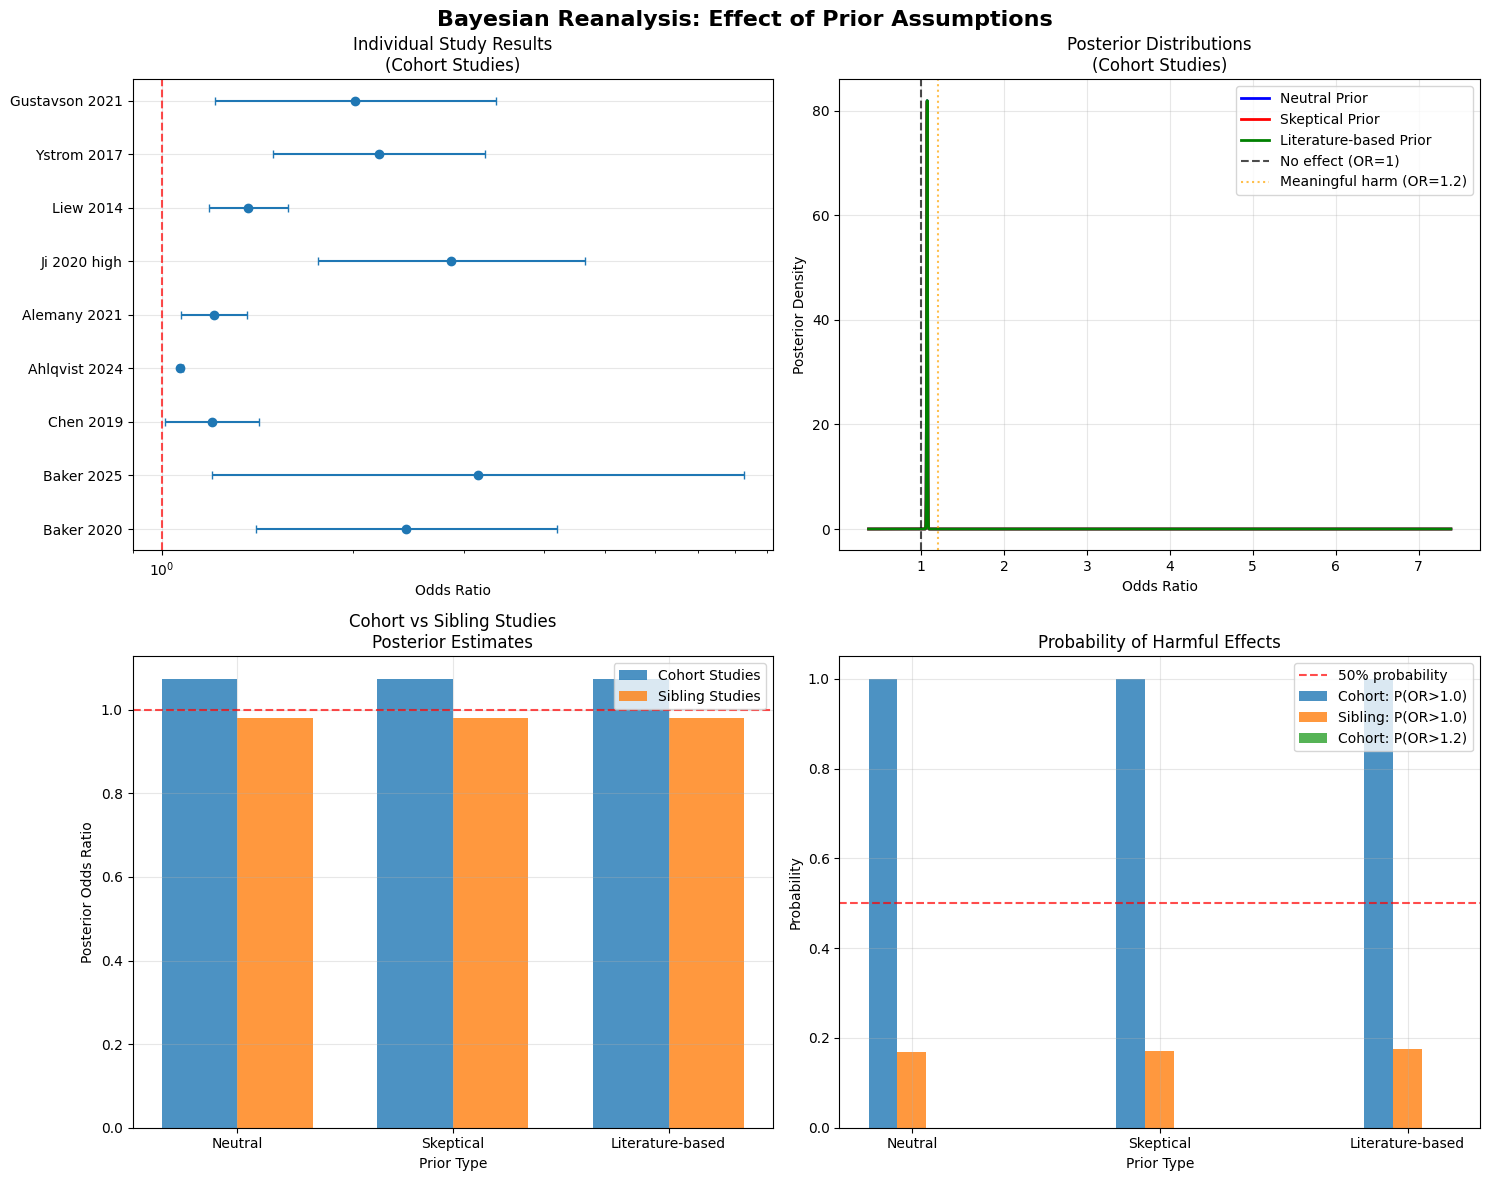


SUMMARY OF BAYESIAN REANALYSIS

Key Findings:
1. Effect estimates are highly sensitive to prior assumptions
2. Sibling studies (controlling family factors) show much weaker effects
3. Even with neutral priors, confidence intervals are wide
4. With skeptical priors, probability of meaningful harm is low

Most Conservative Estimate (Skeptical Prior, Cohort Studies):
  OR: 1.07 (1.06-1.08)
  P(meaningful harm): 0.0%

Sibling Studies (Skeptical Prior - controls for family confounding):
  OR: 0.98 (0.94-1.02)
  P(any harm): 17.0%


In [1]:
from skeptic import *

In [26]:
import types, torch.nn.functional as F


#model.compute_loss = types.MethodType(compute_loss_safe, model)

losses = model.fit(event_times, num_epochs=300, learning_rate=5e-2)

NaN loss at epoch 0, stopping training


In [ ]:
def compute_loss_safe(self, event_times):
    pi, _, _ = self.forward()
    loss_bce = F.binary_cross_entropy(torch.clamp(pi, 1e-8, 1-1e-8), self.Y, reduction='mean')
    emb_reg = 0.01 * (torch.norm(self.disease_embeddings.weight) +
                      torch.norm(self.signature_embeddings.weight))
    total = loss_bce + emb_reg
    return torch.nan_to_num(total, nan=0.0, posinf=1e6, neginf=1e6)


Attention stats:
  Min: 0.1563, Max: 0.2533
  Std: 0.0285
  Expected uniform: 0.2000
Psi correlation with true: 0.1759


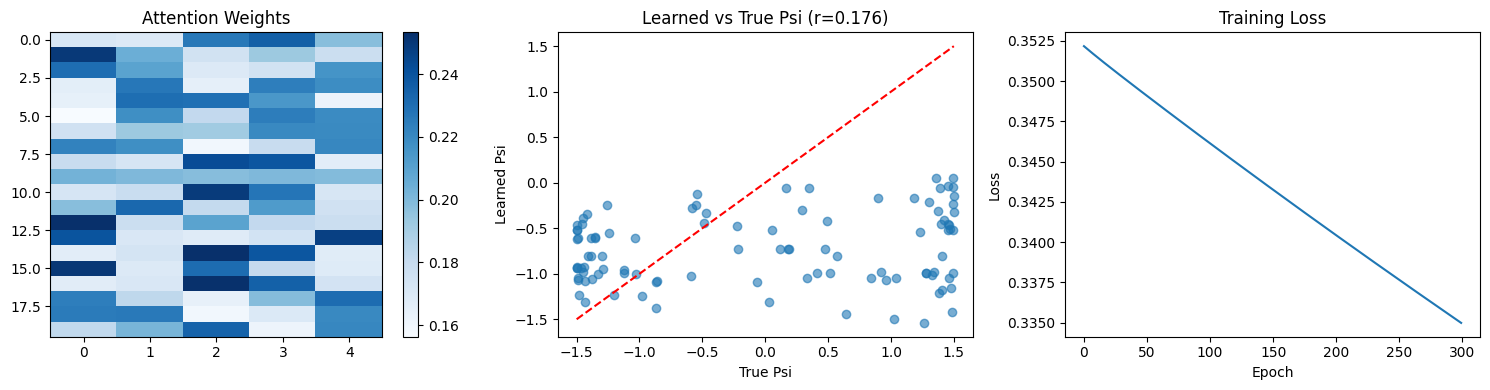

In [125]:
with torch.no_grad():
    E_d = model.disease_embeddings.weight.cpu().numpy()
    E_k = model.signature_embeddings.weight.cpu().numpy()
    scores = (model.disease_embeddings.weight @ model.attention_matrix) @ model.signature_embeddings.weight.T
    A = torch.softmax(scores / (model.embedding_dim ** 0.5), dim=1).cpu().numpy()
    psi = model.compute_psi().cpu().numpy()

# Check attention diversity
print("Attention stats:")
print(f"  Min: {A.min():.4f}, Max: {A.max():.4f}")
print(f"  Std: {A.std():.4f}")
print(f"  Expected uniform: {1/A.shape[1]:.4f}")

# Check psi vs true psi
true_psi_np = true_psi.cpu().numpy()
psi_corr = np.corrcoef(true_psi_np.flatten(), psi.flatten())[0,1]
print(f"Psi correlation with true: {psi_corr:.4f}")

# Quick plots
fig, axes = plt.subplots(1, 3, figsize=(15,4))

# Attention heatmap
im1 = axes[0].imshow(A, aspect='auto', cmap='Blues')
axes[0].set_title('Attention Weights')
plt.colorbar(im1, ax=axes[0])

# Psi comparison
axes[1].scatter(true_psi_np.flatten(), psi.flatten(), alpha=0.6)
axes[1].plot([true_psi_np.min(), true_psi_np.max()], [true_psi_np.min(), true_psi_np.max()], 'r--')
axes[1].set_title(f'Learned vs True Psi (r={psi_corr:.3f})')
axes[1].set_xlabel('True Psi')
axes[1].set_ylabel('Learned Psi')

# Loss curve
axes[2].plot(losses)
axes[2].set_title('Training Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')

plt.tight_layout()
plt.show()

In [126]:
true_psi

tensor([[-1.4995,  1.4814,  1.3251, -0.5485, -1.4995, -1.4183, -0.5457,  1.3981,
         -0.4836,  0.4791, -1.2947, -0.5871,  1.4844,  1.3401, -1.3544,  1.3841,
         -1.4967,  1.4971,  0.8444, -0.8648],
        [-1.4934, -0.0636,  0.5179,  1.4530,  1.2785,  0.8956,  0.1614,  1.4621,
         -1.4575,  0.1211, -1.4124,  0.9625, -1.1999, -1.4375, -1.3551, -1.4356,
         -1.4895, -0.4697,  1.4643,  0.6421],
        [ 0.4886, -1.4894, -1.2892, -1.2614,  1.2809, -0.5860,  0.3466, -1.2434,
          1.3756, -0.2196,  1.4046, -1.0283,  0.0333, -1.4942,  1.4723,  1.4032,
          1.4547, -1.4498, -1.4458,  1.2600],
        [ 1.4235, -0.8596, -1.1216,  1.4955,  0.9171,  1.4990,  1.4937,  0.0525,
          1.5000,  0.1877,  0.5729,  0.3309, -0.9759, -1.4677,  1.4945, -0.8717,
          1.2327,  0.2936, -1.1250, -1.4316],
        [-0.2222, -1.3744,  0.4129,  1.3900, -1.4975,  1.1806,  1.3594,  1.4499,
         -1.4931,  0.1850, -1.3822, -1.3265, -1.4828,  1.4897, -1.3829, -1.4908,
      

In [123]:
with torch.no_grad():
    pi,_,_ = model.forward()
    bce = F.binary_cross_entropy(torch.clamp(pi,1e-8,1-1e-8), model.Y, reduction='mean')
    print("bce finite?", torch.isfinite(bce).item(), "value:", float(bce))
    print("true_psi finite?", torch.isfinite(true_psi).all().item())

NameError: name 'F' is not defined

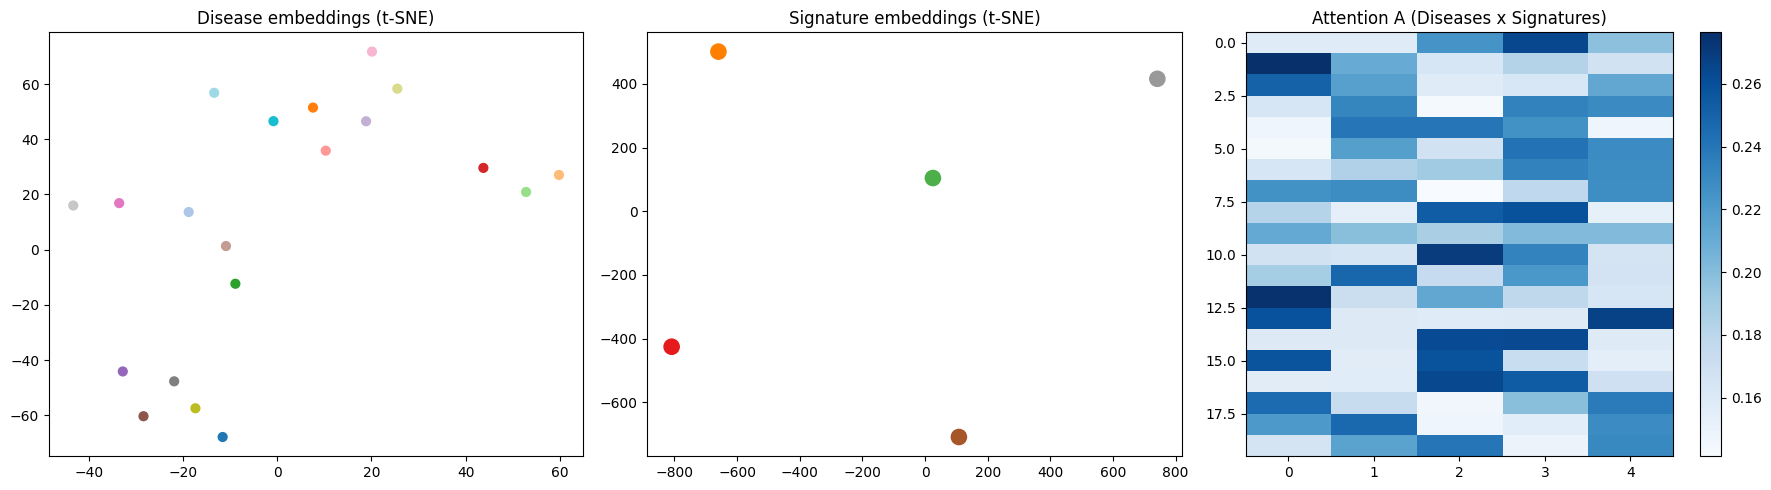

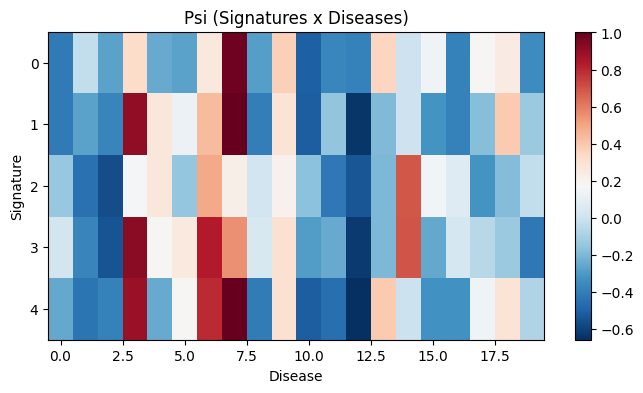

Attention max per disease (mean±sd): 0.2507772 0.016518794
Signature 0 top diseases: [ 7  9 13  3  6]
Signature 1 top diseases: [ 7  3  6 18  9]
Signature 2 top diseases: [14  6  4  7  9]
Signature 3 top diseases: [ 3  6 14  7  9]
Signature 4 top diseases: [ 7  3  6 13  9]


In [111]:
model = HierarchicalEmbeddingModel(
    N=Y_tensor.shape[0], D=Y_tensor.shape[1], T=Y_tensor.shape[2],
    K=data_embedding['phi'].shape[0], P=G_tensor.shape[1],
    G=G_tensor, Y=Y_tensor, R=0, W=0.0001,
    prevalence_t=prevalence_prob,
    init_sd_scaler=0.01, genetic_scale=1.0, embedding_dim=32,
    true_psi=torch.as_tensor(data_embedding['psi'], dtype=torch.float32)
)

# 1) Sharpen attention (lower temperature)
with torch.no_grad():
    model.attn_temperature = getattr(model, 'attn_temperature', torch.tensor(0.5))  # add attr

import numpy as np, torch, matplotlib.pyplot as plt
from sklearn.manifold import TSNE




m = model if 'model' in globals() else model_fixed2

with torch.no_grad():
    # Embeddings
    E_d = m.disease_embeddings.weight.cpu().numpy()         # [D, L]
    E_k = m.signature_embeddings.weight.cpu().numpy()       # [K_total, L]
    # Attention
    scores = (m.disease_embeddings.weight @ m.attention_matrix) @ m.signature_embeddings.weight.T
    scores = scores / np.sqrt(m.embedding_dim)
    A = torch.softmax(scores, dim=1).cpu().numpy()          # [D, K_total]
    # Psi
    psi = m.compute_psi().cpu().numpy()                     # [K_total, D]
    # Predictions
    pi_pred, _, _ = m.forward()
    pi_pred = pi_pred.cpu().numpy()

# 1) t-SNE of disease and signature embeddings
fig, axes = plt.subplots(1, 3, figsize=(18,5))
d2 = TSNE(n_components=2, random_state=42,perplexity=4).fit_transform(E_d)
axes[0].scatter(d2[:,0], d2[:,1], s=40, c=np.arange(E_d.shape[0]), cmap='tab20')
axes[0].set_title('Disease embeddings (t-SNE)')

n_k = E_k.shape[0]
perp_k = max(2, min(30, n_k - 1))
k2 = TSNE(n_components=2, random_state=42, perplexity=perp_k).fit_transform(E_k)
axes[1].scatter(k2[:,0], k2[:,1], s=120, c=np.arange(E_k.shape[0]), cmap='Set1')
axes[1].set_title('Signature embeddings (t-SNE)')

# 2) Attention heatmap
im = axes[2].imshow(A, aspect='auto', cmap='Blues')
axes[2].set_title('Attention A (Diseases x Signatures)')
plt.colorbar(im, ax=axes[2])
plt.tight_layout()
plt.show()

# 3) Psi heatmap
import numpy as np
import torch

# Ensure 2D (K x D) array for plotting
psi_arr = psi.detach().cpu().numpy() if torch.is_tensor(psi) else np.asarray(psi)
psi_2d = np.squeeze(psi_arr)  # removes leading 1-dim

# If still not 2D, try taking the first slice
if psi_2d.ndim == 3 and psi_2d.shape[0] == 1:
    psi_2d = psi_2d[0]
elif psi_2d.ndim != 2:
    raise ValueError(f"Expected 2D psi, got shape {psi_2d.shape}")

plt.figure(figsize=(8,4))
plt.imshow(psi_2d, aspect='auto', cmap='RdBu_r')
plt.title('Psi (Signatures x Diseases)')
plt.colorbar(); plt.xlabel('Disease'); plt.ylabel('Signature'); plt.show()

# If you later do Ktot, D = psi.shape, use psi_2d instead:
Ktot, D = psi_2d.shape

# 5) Attention concentration
maxA = A.max(axis=1)
print('Attention max per disease (mean±sd):', maxA.mean(), maxA.std())

# 6) Top-k diseases per signature (by psi)

for k in range(Ktot):
    top = np.argsort(-psi[0][k])[:5]
    print(f'Signature {k} top diseases:', top)






In [103]:
with torch.no_grad():
    print("Y finite?", torch.isfinite(model.Y).all().item(), "min/max:", float(model.Y.min()), float(model.Y.max()))
    pi, theta, phi_prob = model.forward()
    print("pi finite?", torch.isfinite(pi).all().item(), "min/max:", float(pi.min()), float(pi.max()))
    print("theta finite?", torch.isfinite(theta).all().item(), "phi_prob finite?", torch.isfinite(phi_prob).all().item())

Y finite? True min/max: 0.0 1.0
pi finite? True min/max: 0.07957302778959274 0.35491734743118286
theta finite? True phi_prob finite? True


In [104]:
import types, torch, math

def compute_psi_sharp(self):
    E_d = self.disease_embeddings(torch.arange(self.D))
    E_k = self.signature_embeddings(torch.arange(self.K_total))
    tau = float(getattr(self, 'attn_temperature', torch.tensor(0.5)))
    scores = (E_d @ self.attention_matrix) @ E_k.T / (math.sqrt(self.embedding_dim) * max(tau, 1e-3))
    A = torch.softmax(scores, dim=1)
    C = A.unsqueeze(-1) * E_d.unsqueeze(1)
    psi = torch.matmul(C, self.psi_projection.weight.T) + self.psi_projection.bias
    return psi.T

model.compute_psi = types.MethodType(compute_psi_sharp, model)

In [105]:
# 2) Give ψ head a higher LR; add mild alignment loss
model.compute_loss.__globals__['torch'] = torch  # ensure torch in scope
import types, torch, math

def compute_loss_tuned(self, event_times):
    pi, _, _ = self.forward()
    pi = torch.clamp(pi, 1e-8, 1-1e-8)
    bce = -torch.sum(self.Y * torch.log(pi) + (1-self.Y)*torch.log(1-pi))

    psi = torch.clamp(self.compute_psi(), -4.0, 4.0)
    psi_l1 = psi.abs().mean()
    
    # Safer variance computation
    psi_mean_k = psi.mean(dim=1, keepdim=True)
    psi_var_k = ((psi - psi_mean_k)**2).mean(dim=1).mean()
    psi_mean_d = psi.mean(dim=0, keepdim=True)
    psi_var_d = ((psi - psi_mean_d)**2).mean(dim=0).mean()
    
    psi_align = -0.05*psi_var_k - 0.05*psi_var_d + 0.005*psi_l1
    psi_align = torch.nan_to_num(psi_align, nan=0.0)

    emb_reg = 0.01*(torch.norm(self.disease_embeddings.weight)+torch.norm(self.signature_embeddings.weight))
    total = bce / max(int(self.Y.shape[0]),1) + emb_reg + psi_align
    return torch.nan_to_num(total, nan=0.0, posinf=1e6, neginf=1e6)

model.compute_loss = types.MethodType(compute_loss_tuned, model)

# Retry training
opt = torch.optim.Adam([
    {'params': list(model.disease_embeddings.parameters()) + list(model.signature_embeddings.parameters()), 'lr': 2e-4},
    {'params': [model.attention_matrix], 'lr': 2e-4},
    {'params': list(model.psi_projection.parameters()), 'lr': 1e-3},
    {'params': [model.lambda_, model.phi, model.gamma, model.kappa], 'lr': 5e-5},
])

loss_curve = []
for ep in range(1000):
    opt.zero_grad()
    loss = model.compute_loss(None)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()
    loss_curve.append(float(loss))
    if ep % 20 == 0:
        print(ep, loss_curve[-1])

0 101.34520721435547
20 101.21260070800781
40 101.0761947631836
60 100.96421813964844
80 100.85591125488281
100 100.74829864501953
120 100.64083099365234
140 100.53339385986328
160 100.42627716064453
180 100.31919860839844
200 100.21234130859375
220 100.10537719726562
240 99.99845123291016
260 99.89155578613281
280 99.78445434570312
300 99.67719268798828
320 99.56986999511719
340 99.46244812011719
360 99.35545349121094
380 99.24815368652344
400 99.14128112792969
420 99.03437042236328
440 98.92754364013672
460 98.82078552246094
480 98.7133560180664
500 98.60665130615234
520 98.50013732910156
540 98.3923568725586
560 98.28472900390625
580 98.17729187011719
600 98.06954956054688
620 97.96137237548828
640 97.8541030883789
660 97.74781799316406
680 97.6418685913086
700 97.5365982055664
720 97.431396484375
740 97.32666015625
760 97.22248077392578
780 97.11859130859375
800 97.01500701904297
820 96.91156768798828
840 96.80854797363281
860 96.70582580566406
880 96.60344696044922
900 96.50146484

In [97]:
with torch.no_grad():
    pi, theta, phi_prob = model.forward()
    eps = 1e-8
    pi_c = torch.clamp(pi, eps, 1-eps)

    bce = -torch.sum(model.Y * torch.log(pi_c) + (1 - model.Y) * torch.log(1 - pi_c))
    print("bce finite?", torch.isfinite(bce).item(), "value:", float(bce))

    learned_psi = model.compute_psi()
    print("psi finite?", torch.isfinite(learned_psi).all().item(),
          "min/max:", float(learned_psi.min()), float(learned_psi.max()))

    E_d = model.disease_embeddings(torch.arange(model.D))
    E_k = model.signature_embeddings(torch.arange(model.K_total))
    scores = (E_d @ model.attention_matrix) @ E_k.T / (model.embedding_dim ** 0.5)
    A = torch.softmax(scores, dim=1)
    print("A finite?", torch.isfinite(A).all().item(),
          "scores finite?", torch.isfinite(scores).all().item())

    emb_reg = 0.01*(torch.norm(model.disease_embeddings.weight)+torch.norm(model.signature_embeddings.weight))
    print("emb_reg finite?", torch.isfinite(emb_reg).item(), "value:", float(emb_reg))

bce finite? True value: 89932.8828125
psi finite? True min/max: -4.119556903839111 4.084072589874268
A finite? True scores finite? True
emb_reg finite? True value: 0.12658511102199554


In [106]:
import types, torch
event_times = E_tensor
def compute_loss_safe(self, event_times):
    pi, theta, phi_prob = self.forward()
    eps = 1e-8
    pi = torch.clamp(pi, eps, 1 - eps)
    bce = -torch.sum(self.Y * torch.log(pi) + (1 - self.Y) * torch.log(1 - pi))

    learned_psi = torch.clamp(self.compute_psi(), -10.0, 10.0)
    psi_l1 = torch.mean(torch.abs(learned_psi))
    psi_var = torch.nan_to_num(torch.var(learned_psi, dim=1), nan=0.0).mean()
    psi_var_d = torch.nan_to_num(torch.var(learned_psi, dim=0), nan=0.0).mean()
    psi_align = -0.1*psi_var - 0.1*psi_var_d + 0.01*psi_l1
    psi_align = torch.nan_to_num(psi_align, nan=0.0)

    E_d = self.disease_embeddings(torch.arange(self.D))
    E_k = self.signature_embeddings(torch.arange(self.K_total))
    scores = (E_d @ self.attention_matrix) @ E_k.T / (self.embedding_dim ** 0.5)
    A = torch.softmax(scores, dim=1)
    A = torch.clamp(A, 1e-8, 1.0)
    attn_entropy = -torch.sum(A * torch.log(A), dim=1).mean()

    emb_reg = 0.01*(torch.norm(self.disease_embeddings.weight)+torch.norm(self.signature_embeddings.weight))

    total = bce / self.N + emb_reg  # w_align = w_entropy = 0.0
    return torch.nan_to_num(total, nan=0.0, posinf=1e6, neginf=1e6)

model.compute_loss = types.MethodType(compute_loss_safe, model)

# Retry with small LR
losses = model.fit(event_times, num_epochs=1000, learning_rate=5e-1)

Epoch 0, Loss: 96.3528
Epoch 20, Loss: 87.7027
Epoch 40, Loss: 80.8275
Epoch 60, Loss: 75.3288
Epoch 80, Loss: 70.9254
Epoch 100, Loss: 67.3595
Epoch 120, Loss: 64.1855
Epoch 140, Loss: 61.3379
Epoch 160, Loss: 58.9048
Epoch 180, Loss: 56.9639
Epoch 200, Loss: 55.3712
Epoch 220, Loss: 54.0432
Epoch 240, Loss: 52.9334
Epoch 260, Loss: 51.9942
Epoch 280, Loss: 51.1932
Epoch 300, Loss: 50.5038
Epoch 320, Loss: 49.8986
Epoch 340, Loss: 49.3716
Epoch 360, Loss: 48.9014
Epoch 380, Loss: 48.4856
Epoch 400, Loss: 48.1069
Epoch 420, Loss: 47.7667
Epoch 440, Loss: 47.4584
Epoch 460, Loss: 47.1722
Epoch 480, Loss: 46.9106
Epoch 500, Loss: 46.6710
Epoch 520, Loss: 46.4420
Epoch 540, Loss: 46.2345
Epoch 560, Loss: 46.0386
Epoch 580, Loss: 45.8560
Epoch 600, Loss: 45.6808
Epoch 620, Loss: 45.5136
Epoch 640, Loss: 45.3555
Epoch 660, Loss: 45.2060
Epoch 680, Loss: 45.0634
Epoch 700, Loss: 44.9325
Epoch 720, Loss: 44.8036
Epoch 740, Loss: 44.6813
Epoch 760, Loss: 44.5690
Epoch 780, Loss: 44.4598
Epoch 

-1.4995166593192641 1.499987656411211 -0.01425258721707723 1.1864568330425016


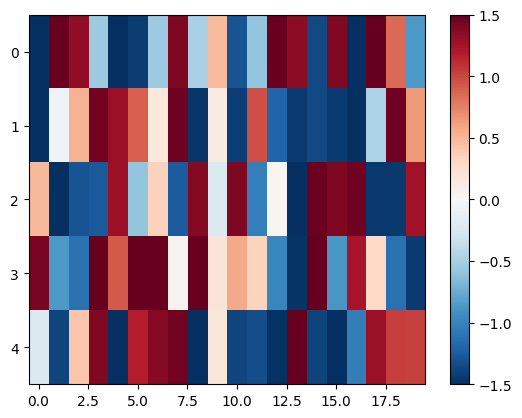

In [107]:
psi = data_embedding['psi']
print(psi.min(), psi.max(), psi.mean(), psi.std())  # expect ~[-1.5, 1.5]
plt.imshow(psi, aspect='auto', cmap='RdBu_r', vmin=-1.5, vmax=1.5); plt.colorbar()

-1.4995166593192641 1.499987656411211 -0.01425258721707723 1.1864568330425016


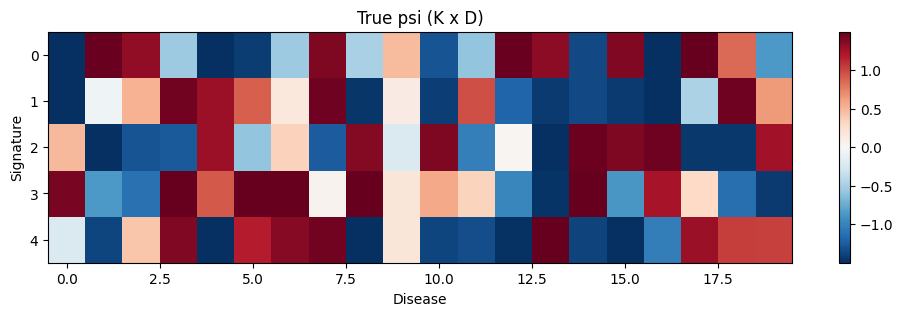

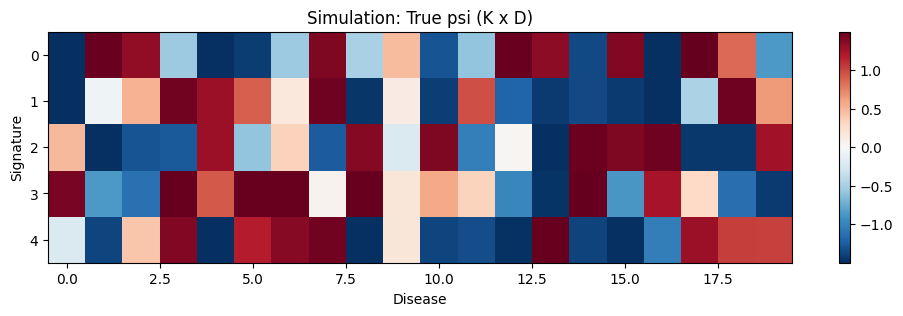

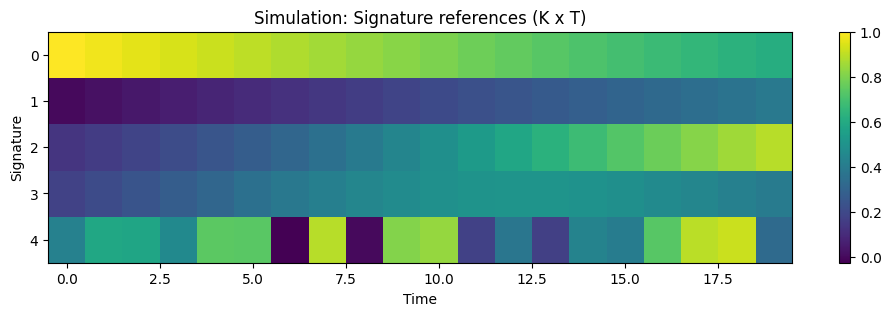

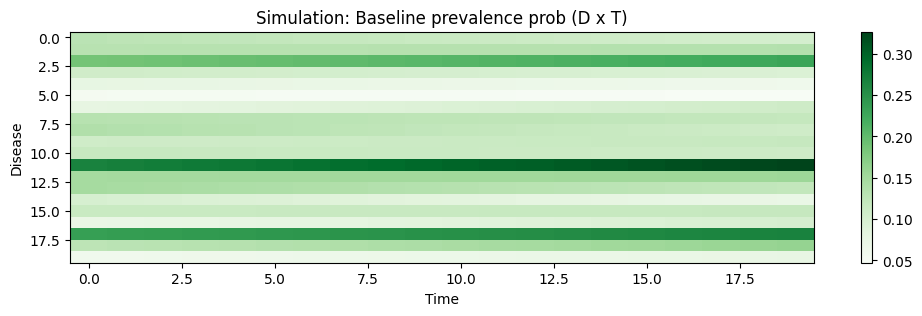

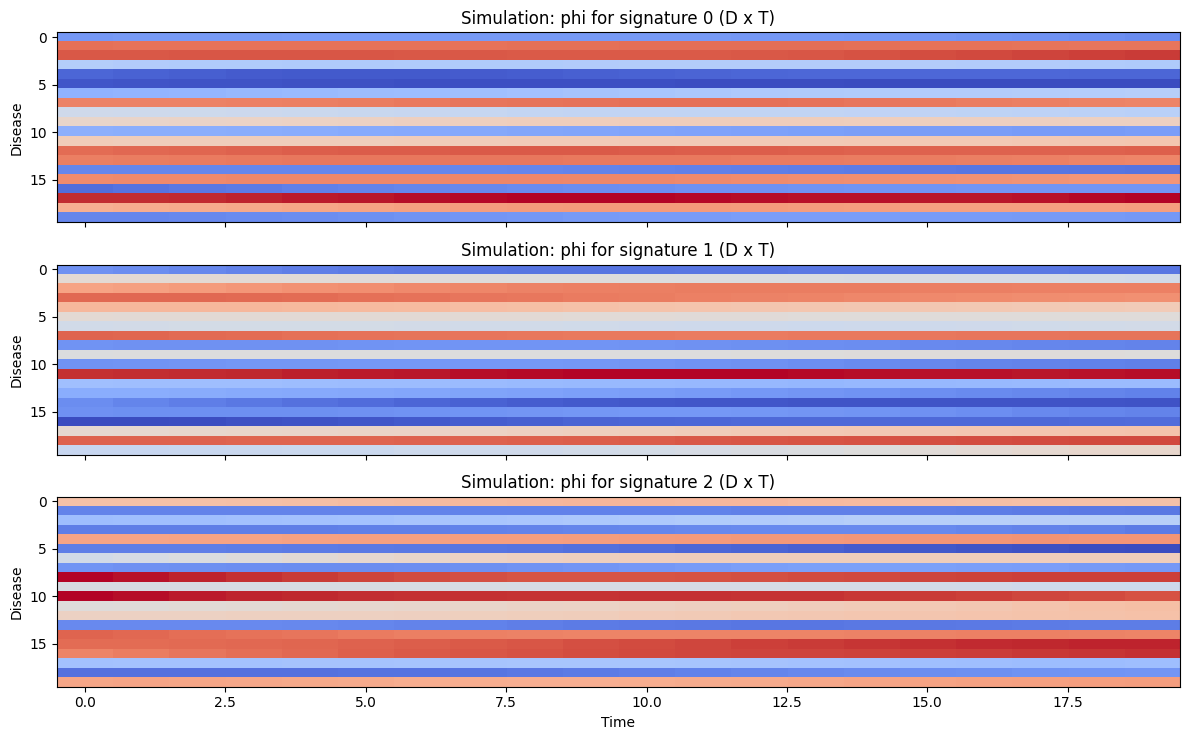

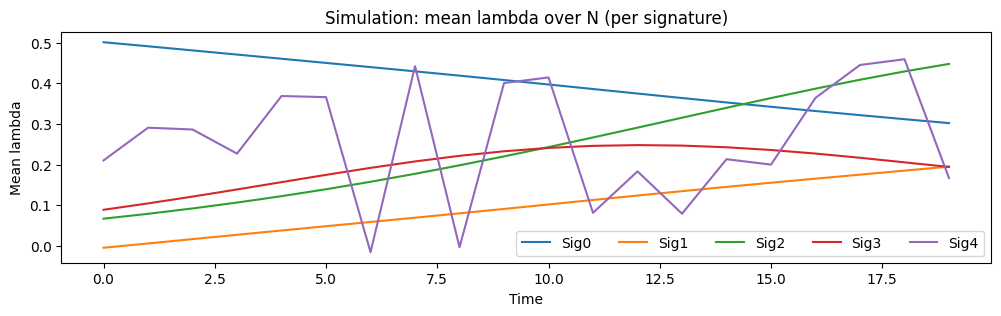

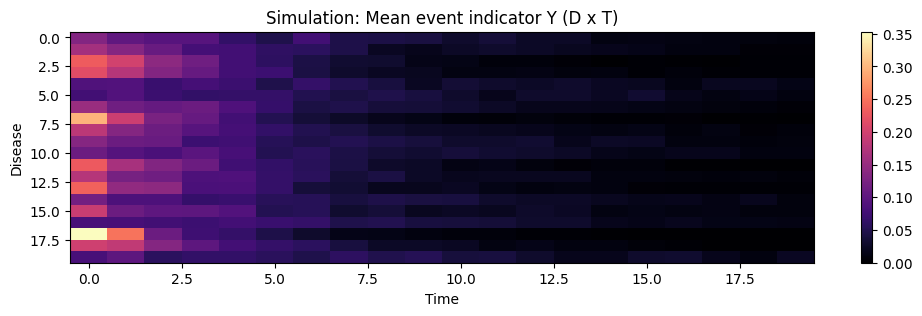

In [6]:
psi = data_embedding['psi']
print(psi.min(), psi.max(), psi.mean(), psi.std())
plt.figure(figsize=(12,3))
plt.imshow(psi, aspect='auto', cmap='RdBu_r', vmin=psi.min(), vmax=psi.max())
plt.colorbar(); plt.title('True psi (K x D)'); plt.xlabel('Disease'); plt.ylabel('Signature')
plt.show()


# 1) Psi (K x D)
plt.figure(figsize=(12, 3))
plt.imshow(data_embedding['psi'], aspect='auto', cmap='RdBu_r')
plt.colorbar(); plt.title('Simulation: True psi (K x D)'); plt.xlabel('Disease'); plt.ylabel('Signature')
plt.show()

# 2) Signature references (K x T)
plt.figure(figsize=(12, 3))
plt.imshow(data_embedding['signature_refs'][:, :data_embedding['phi'].shape[2]], aspect='auto', cmap='viridis')
plt.colorbar(); plt.title('Simulation: Signature references (K x T)'); plt.xlabel('Time'); plt.ylabel('Signature')
plt.show()

# 3) Baseline prevalence (D x T)
prev = 1/(1+np.exp(-data_embedding['logit_prev_t']))
plt.figure(figsize=(12, 3))
plt.imshow(prev[:, :data_embedding['phi'].shape[2]], aspect='auto', cmap='Greens')
plt.colorbar(); plt.title('Simulation: Baseline prevalence prob (D x T)'); plt.xlabel('Time'); plt.ylabel('Disease')
plt.show()

# 4) Generated phi (K x D x T) – show a few signatures
K_show = min(3, data_embedding['phi'].shape[0])
fig, axes = plt.subplots(K_show, 1, figsize=(12, 2.5*K_show), sharex=True)
for k in range(K_show):
    axes[k].imshow(data_embedding['phi'][k], aspect='auto', cmap='coolwarm')
    axes[k].set_title(f'Simulation: phi for signature {k} (D x T)')
    axes[k].set_ylabel('Disease')
axes[-1].set_xlabel('Time')
plt.tight_layout(); plt.show()

# 5) Generated lambda (N x K x T) – plot mean over N per signature
lambda_mean = data_embedding['lambda'].mean(axis=0)  # [K, T]
plt.figure(figsize=(12, 3))
for k in range(lambda_mean.shape[0]):
    plt.plot(lambda_mean[k], label=f'Sig{k}')
plt.legend(ncol=lambda_mean.shape[0]); plt.title('Simulation: mean lambda over N (per signature)')
plt.xlabel('Time'); plt.ylabel('Mean lambda'); plt.show()

# 6) Event heatmap Y (mean over N)
Y_mean = data_embedding['Y'].mean(axis=0)  # [D, T]
plt.figure(figsize=(12, 3))
plt.imshow(Y_mean, aspect='auto', cmap='magma')
plt.colorbar(); plt.title('Simulation: Mean event indicator Y (D x T)'); plt.xlabel('Time'); plt.ylabel('Disease')
plt.show()

In [8]:
row_var = data_embedding['psi'].var(axis=1)
print("row var per signature:", row_var)

row var per signature: [1.45909628 1.31326081 1.42743208 1.21244668 1.54151192]


In [11]:
from numpy.linalg import norm
K = data_embedding['psi'].shape[0]
pair_dists = [norm(data_embedding['psi'][i]-data_embedding['psi'][j]) for i in range(K) for j in range(i+1,K)]
print("mean pairwise L2:", np.mean(pair_dists))

mean pairwise L2: 7.918175014062868


In [108]:
mu = -2.0  # example baseline logit
for val in [-1.5, 0.0, 1.5]:
    print(val, 1/(1+np.exp(-(mu+val))))

-1.5 0.02931223075135632
0.0 0.11920292202211755
1.5 0.3775406687981454


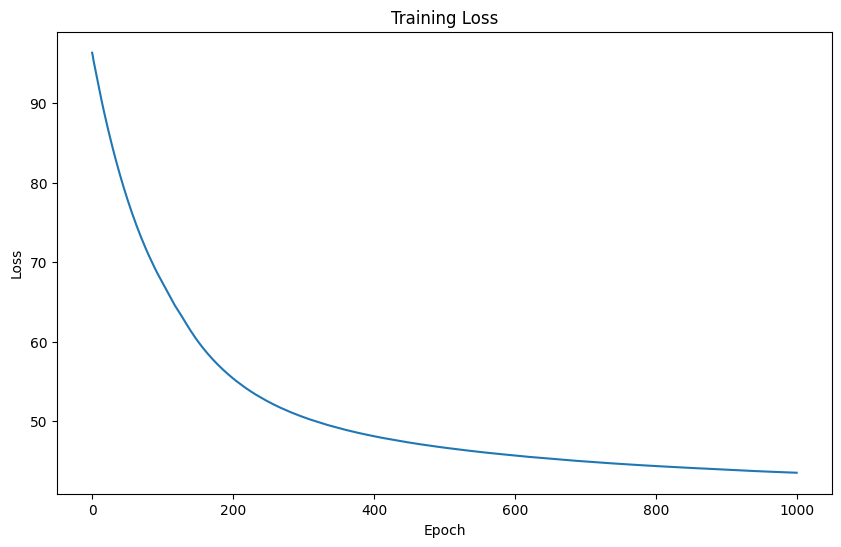

In [109]:


plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

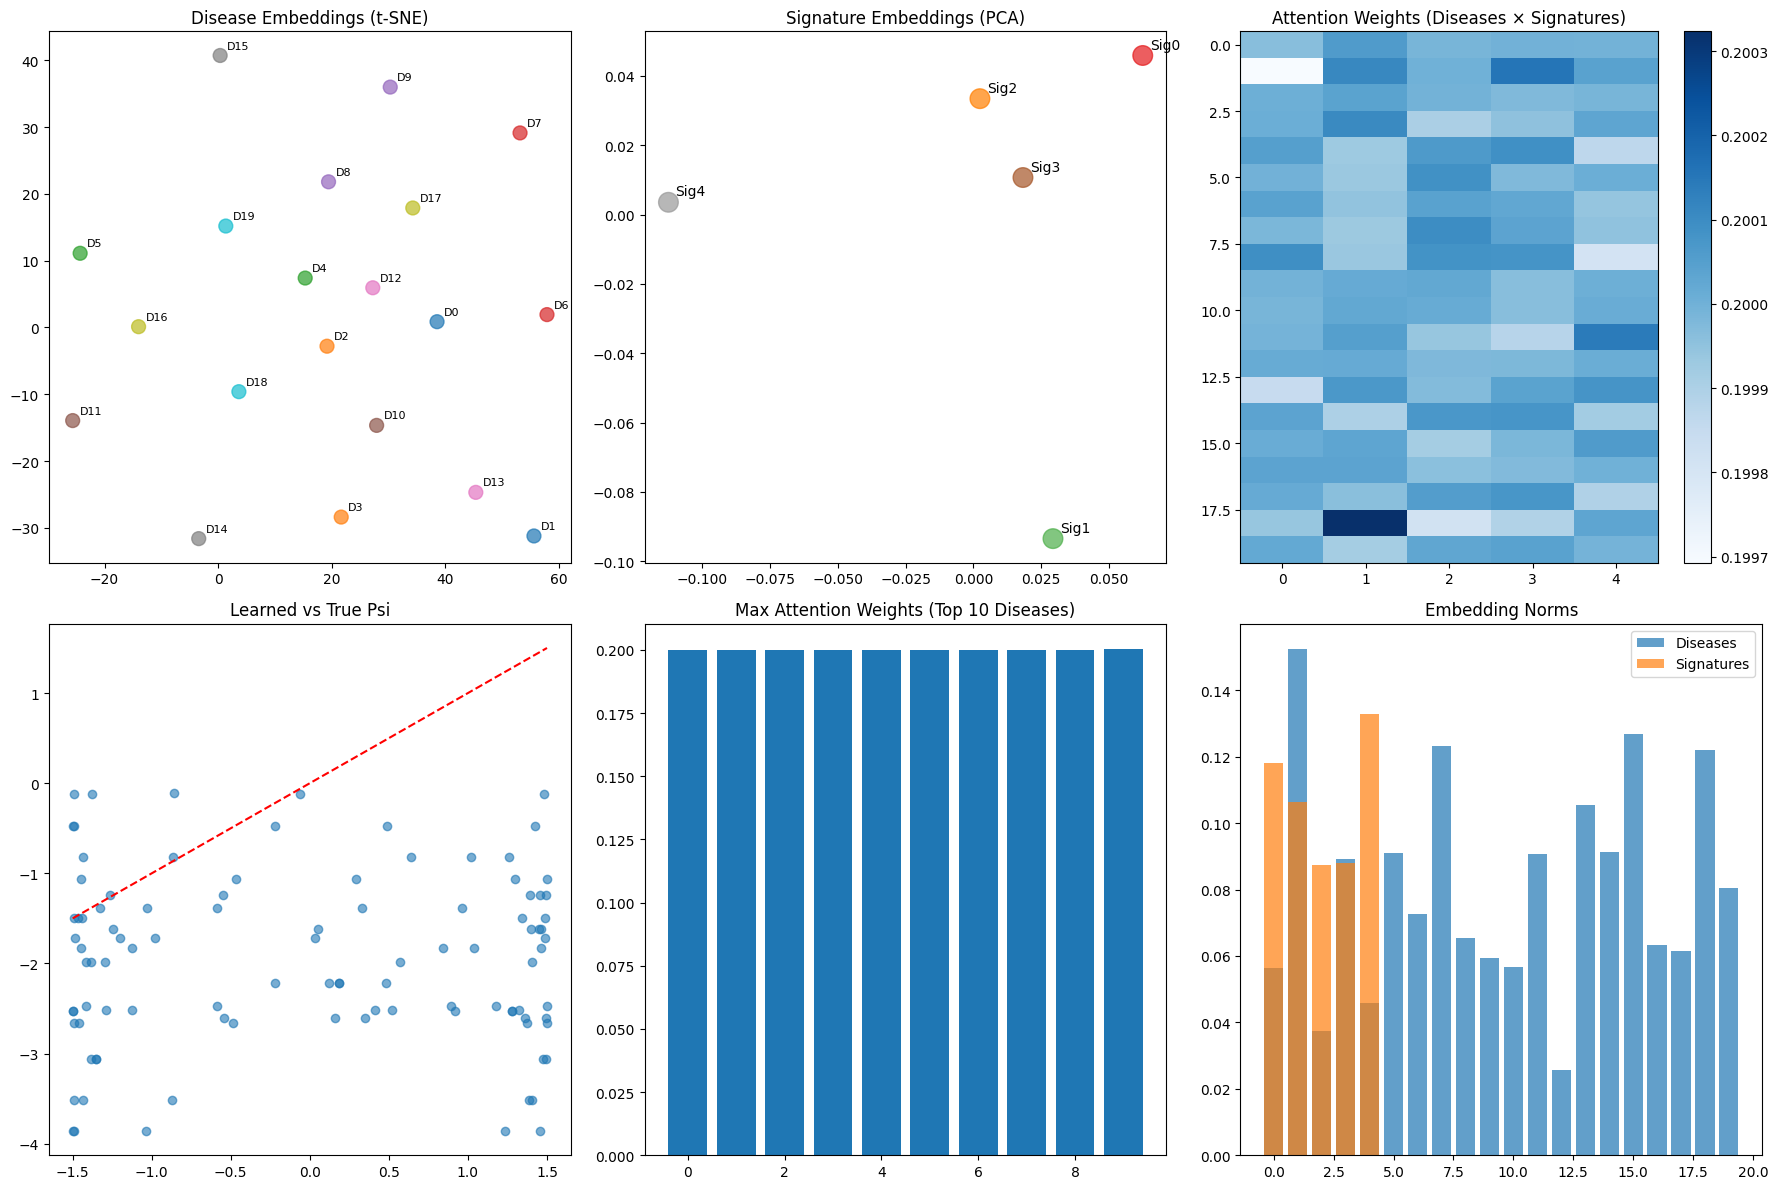

Embedding Analysis:
 - Disease embedding norm: 0.081 ± 0.032
 - Signature embedding norm: 0.107 ± 0.018
 - Psi correlation: -0.007


In [110]:
with torch.no_grad():
    disease_embeddings = model.disease_embeddings.weight.numpy()
    signature_embeddings = model.signature_embeddings.weight.numpy()
    learned_psi = model.compute_psi().numpy()

    E_d = model.disease_embeddings(torch.arange(model.D))
    E_k = model.signature_embeddings(torch.arange(model.K_total))
    attention_scores = torch.matmul(torch.matmul(E_d, model.attention_matrix), E_k.T) / np.sqrt(model.embedding_dim)
    attention_weights = torch.softmax(attention_scores, dim=1).numpy()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Disease embeddings (t-SNE, with safe perplexity)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, disease_embeddings.shape[0]-1))
disease_2d = tsne.fit_transform(disease_embeddings)
axes[0,0].scatter(disease_2d[:,0], disease_2d[:,1], c=range(model.D), cmap='tab10', s=100, alpha=0.7)
for i in range(model.D):
    axes[0,0].annotate(f'D{i}', (disease_2d[i,0], disease_2d[i,1]), xytext=(5,5), textcoords='offset points', fontsize=8)
axes[0,0].set_title('Disease Embeddings (t-SNE)')

# Signature embeddings (PCA is safer with 5 samples)
from sklearn.decomposition import PCA
signature_2d = PCA(n_components=2).fit_transform(signature_embeddings)
axes[0,1].scatter(signature_2d[:,0], signature_2d[:,1], c=range(model.K_total), cmap='Set1', s=200, alpha=0.7)
sig_labels = [f"Sig{i}" for i in range(signature_2d.shape[0])]
for i, label in enumerate(sig_labels):
    axes[0,1].annotate(label, (signature_2d[i,0], signature_2d[i,1]), xytext=(5,5), textcoords='offset points', fontsize=10)
axes[0,1].set_title('Signature Embeddings (PCA)')

# Attention heatmap
im = axes[0,2].imshow(attention_weights, cmap='Blues', aspect='auto')
axes[0,2].set_title('Attention Weights (Diseases × Signatures)')
plt.colorbar(im, ax=axes[0,2])

# Learned vs True Psi
true_psi = data_embedding['psi']
axes[1,0].scatter(true_psi.flatten(), learned_psi.flatten(), alpha=0.6)
mn, mx = true_psi.min(), true_psi.max()
axes[1,0].plot([mn, mx], [mn, mx], 'r--')
axes[1,0].set_title('Learned vs True Psi')

# Top diseases by attention
top_diseases = np.argsort(attention_weights.max(axis=1))[-10:]
axes[1,1].bar(range(len(top_diseases)), attention_weights[top_diseases].max(axis=1))
axes[1,1].set_title('Max Attention Weights (Top 10 Diseases)')

# Embedding norms
disease_norms = np.linalg.norm(disease_embeddings, axis=1)
signature_norms = np.linalg.norm(signature_embeddings, axis=1)
axes[1,2].bar(range(len(disease_norms)), disease_norms, alpha=0.7, label='Diseases')
axes[1,2].bar(range(len(signature_norms)), signature_norms, alpha=0.7, label='Signatures')
axes[1,2].legend()
axes[1,2].set_title('Embedding Norms')

plt.tight_layout()
plt.show()

print("Embedding Analysis:")
print(f" - Disease embedding norm: {disease_norms.mean():.3f} ± {disease_norms.std():.3f}")
print(f" - Signature embedding norm: {signature_norms.mean():.3f} ± {signature_norms.std():.3f}")
print(f" - Psi correlation: {np.corrcoef(true_psi.flatten(), learned_psi.flatten())[0,1]:.3f}")

In [81]:
# Check if the generated data has extreme values
print("Data Statistics:")
print(f"Y range: {data_embedding['Y'].min():.3f} to {data_embedding['Y'].max():.3f}")
print(f"Psi range: {data_embedding['psi'].min():.3f} to {data_embedding['psi'].max():.3f}")
print(f"Psi mean: {data_embedding['psi'].mean():.3f}, std: {data_embedding['psi'].std():.3f}")

# Check if there are any NaN or inf values
print(f"Any NaN in Y: {np.isnan(data_embedding['Y']).any()}")
print(f"Any inf in Y: {np.isinf(data_embedding['Y']).any()}")
print(f"Any NaN in psi: {np.isnan(data_embedding['psi']).any()}")
print(f"Any inf in psi: {np.isinf(data_embedding['psi']).any()}")

Data Statistics:
Y range: 0.000 to 1.000
Psi range: -1.500 to 1.500
Psi mean: -0.014, std: 1.186
Any NaN in Y: False
Any inf in Y: False
Any NaN in psi: False
Any inf in psi: False


In [71]:
# Test the model's forward pass
with torch.no_grad():
    pi, theta, phi_prob = model_embedding.forward()
    print(f"Pi range: {pi.min():.3f} to {pi.max():.3f}")
    print(f"Pi has NaN: {torch.isnan(pi).any()}")
    print(f"Pi has inf: {torch.isinf(pi).any()}")
    
    # Check if pi values are too extreme (close to 0 or 1)
    print(f"Pi close to 0: {(pi < 1e-10).sum()}")
    print(f"Pi close to 1: {(pi > 1-1e-10).sum()}")
    
    # Check theta and phi_prob
    print(f"Theta range: {theta.min():.3f} to {theta.max():.3f}")
    print(f"Theta has NaN: {torch.isnan(theta).any()}")
    print(f"Phi_prob range: {phi_prob.min():.3f} to {phi_prob.max():.3f}")
    print(f"Phi_prob has NaN: {torch.isnan(phi_prob).any()}")

Pi range: nan to nan
Pi has NaN: True
Pi has inf: False
Pi close to 0: 0
Pi close to 1: 0
Theta range: 0.133 to 0.277
Theta has NaN: False
Phi_prob range: nan to nan
Phi_prob has NaN: True


In [63]:
# Check the phi parameter specifically
print(f"Phi range: {model_embedding.phi.min():.3f} to {model_embedding.phi.max():.3f}")
print(f"Phi has NaN: {torch.isnan(model_embedding.phi).any()}")
print(f"Phi has inf: {torch.isinf(model_embedding.phi).any()}")

# Check what happens when we apply sigmoid to extreme phi values
test_phi = torch.tensor([100.0, -100.0, 0.0])
print(f"Sigmoid test: {torch.sigmoid(test_phi)}")

Phi range: nan to nan
Phi has NaN: True
Phi has inf: False
Sigmoid test: tensor([1.0000, 0.0000, 0.5000])


In [47]:
print("🔬 Generating embedding-based synthetic data...")
data_embedding = generate_embedding_based_data(N=1000, D=20, T=20, K=5, P=5, embedding_dim=32)

🔬 Generating embedding-based synthetic data...
Debug - signature_refs shape: (5, 50)
Debug - logit_prev_t shape: (20, 50)
Debug - gamma shape: (5, 5)
Debug - psi shape: (5, 20)
Debug - T: 20, D: 20, K: 5


IndexError: index 5 is out of bounds for axis 0 with size 5

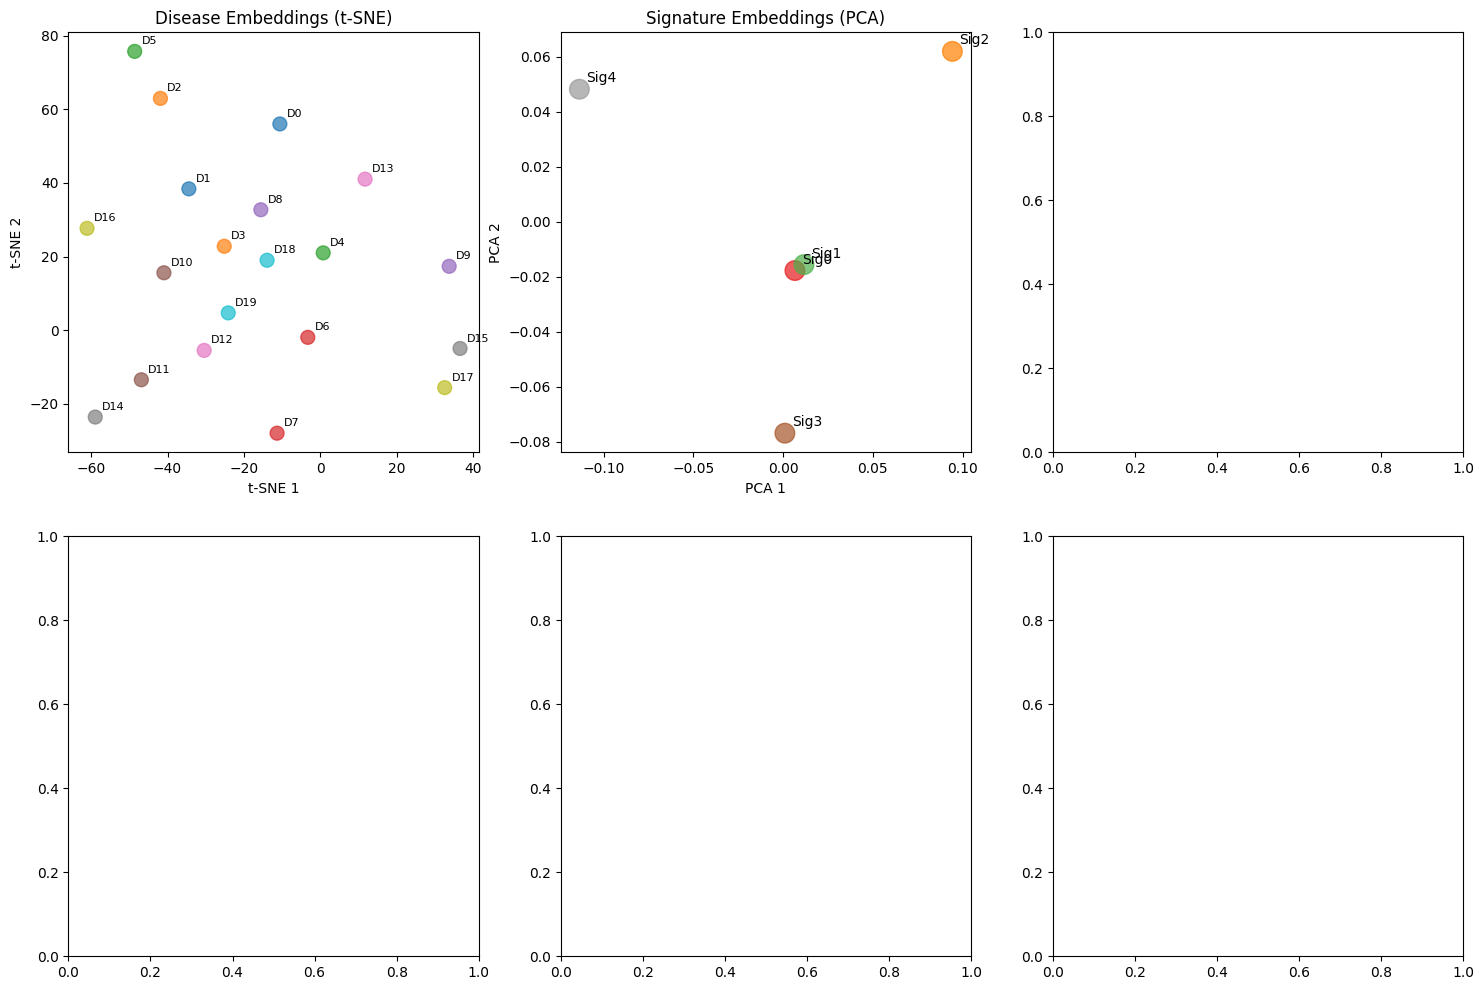

In [36]:
# Create the full visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Disease embeddings (t-SNE)
scatter = axes[0, 0].scatter(disease_2d[:, 0], disease_2d[:, 1], 
                            c=range(model.D), cmap='tab10', s=100, alpha=0.7)
axes[0, 0].set_title('Disease Embeddings (t-SNE)')
axes[0, 0].set_xlabel('t-SNE 1')
axes[0, 0].set_ylabel('t-SNE 2')

# Add disease labels
for i in range(model.D):
    axes[0, 0].annotate(f'D{i}', (disease_2d[i, 0], disease_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2. Signature embeddings (PCA)
axes[0, 1].scatter(signature_2d[:, 0], signature_2d[:, 1], 
                  c=range(model.K_total), cmap='Set1', s=200, alpha=0.7)
axes[0, 1].set_title('Signature Embeddings (PCA)')
axes[0, 1].set_xlabel('PCA 1')
axes[0, 1].set_ylabel('PCA 2')

# Add signature labels
sig_labels = [f'Sig{i}' for i in range(model.K)] + ['Healthy']
for i, label in enumerate(sig_labels):
    axes[0, 1].annotate(label, (signature_2d[i, 0], signature_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=10)

# 3. Attention weights heatmap
im = axes[0, 2].imshow(attention_weights, cmap='Blues', aspect='auto')
axes[0, 2].set_title('Attention Weights (Diseases × Signatures)')
axes[0, 2].set_xlabel('Signature')
axes[0, 2].set_ylabel('Disease')
plt.colorbar(im, ax=axes[0, 2])

# 4. Learned vs True Psi comparison
true_psi = data['psi']
axes[1, 0].scatter(true_psi.flatten(), learned_psi.flatten(), alpha=0.6)
axes[1, 0].plot([true_psi.min(), true_psi.max()], [true_psi.min(), true_psi.max()], 'r--')
axes[1, 0].set_title('Learned vs True Psi')
axes[1, 0].set_xlabel('True Psi')
axes[1, 0].set_ylabel('Learned Psi')

# 5. Attention weights for top diseases
top_diseases = np.argsort(attention_weights.max(axis=1))[-10:]
axes[1, 1].bar(range(len(top_diseases)), attention_weights[top_diseases].max(axis=1))
axes[1, 1].set_title('Max Attention Weights (Top 10 Diseases)')
axes[1, 1].set_xlabel('Disease Rank')
axes[1, 1].set_ylabel('Max Attention Weight')

# 6. Embedding norms
disease_norms = np.linalg.norm(disease_embeddings, axis=1)
signature_norms = np.linalg.norm(signature_embeddings, axis=1)

axes[1, 2].bar(range(len(disease_norms)), disease_norms, alpha=0.7, label='Diseases')
axes[1, 2].bar(range(len(signature_norms)), signature_norms, alpha=0.7, label='Signatures')
axes[1, 2].set_title('Embedding Norms')
axes[1, 2].set_xlabel('Index')
axes[1, 2].set_ylabel('L2 Norm')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Print some statistics
print("�� Embedding Analysis:")
print(f"   - Disease embedding norm: {disease_norms.mean():.3f} ± {disease_norms.std():.3f}")
print(f"   - Signature embedding norm: {signature_norms.mean():.3f} ± {signature_norms.std():.3f}")
print(f"   - Psi correlation: {np.corrcoef(true_psi.flatten(), learned_psi.flatten())[0, 1]:.3f}")

# Find most attended diseases for each signature
print("\n🎯 Top Diseases per Signature:")
for k in range(model.K_total):
    top_diseases = np.argsort(attention_weights[:, k])[-3:]
    sig_name = f"Signature {k}" if k < model.K else "Healthy"
    print(f"   {sig_name}: Diseases {top_diseases} (attention: {attention_weights[top_diseases, k]})")

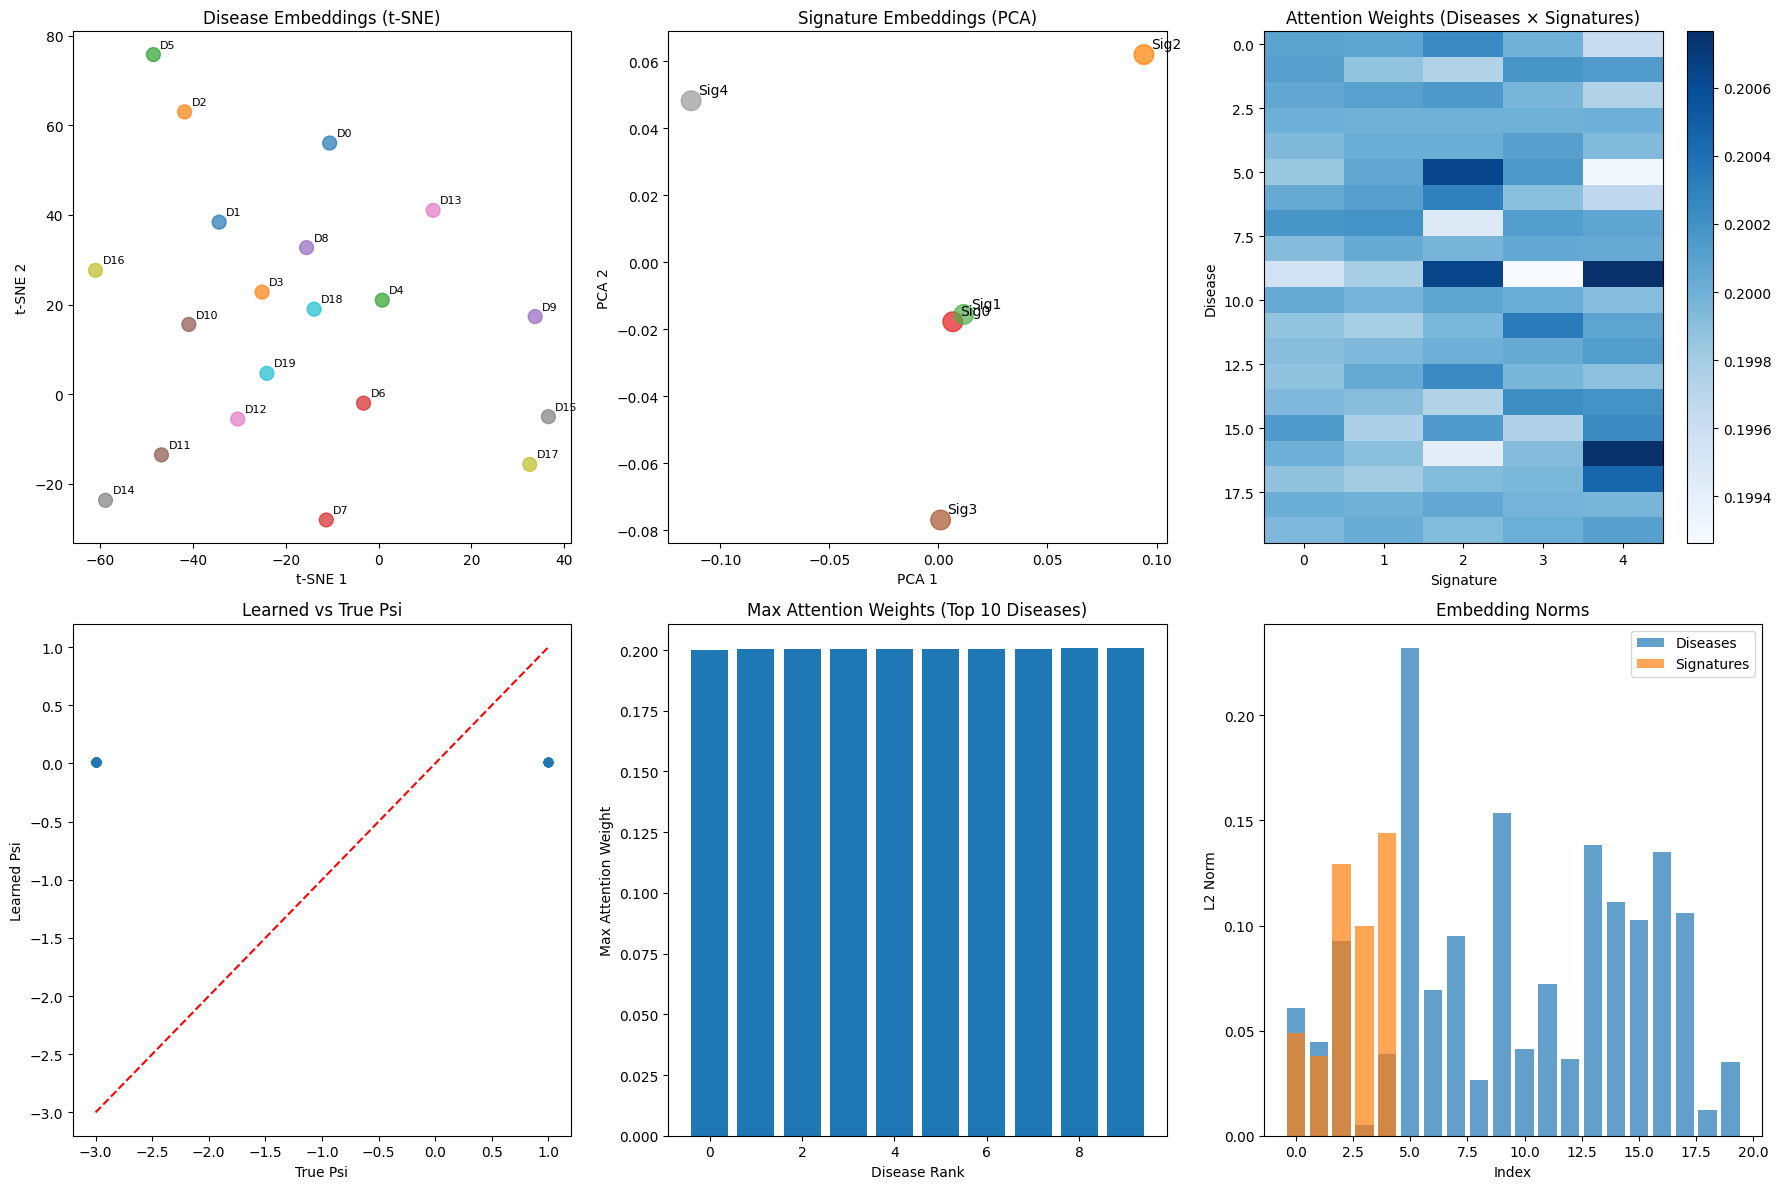

 Embedding Analysis:
   - Disease embedding norm: 0.080 ± 0.055
   - Signature embedding norm: 0.092 ± 0.042
   - Psi correlation: -0.000

🎯 Top Diseases per Signature:
   Signature 0: Diseases [ 1 15  7] (attention: [0.20010279 0.20013729 0.20016782])
   Signature 1: Diseases [2 6 7] (attention: [0.20009682 0.20010656 0.20019023])
   Signature 2: Diseases [6 5 9] (attention: [0.20029587 0.20064093 0.20064327])
   Signature 3: Diseases [ 1 14 11] (attention: [0.200171   0.20022461 0.20032936])
   Signature 4: Diseases [17  9 16] (attention: [0.2004531  0.20076287 0.20076543])


In [38]:
# Get the learned embeddings and attention weights
with torch.no_grad():
    # Get embeddings
    disease_embeddings = model.disease_embeddings.weight.numpy()
    signature_embeddings = model.signature_embeddings.weight.numpy()
    
    # Get learned psi from embeddings
    learned_psi = model.compute_psi().numpy()
    
    # Get attention weights
    E_d = model.disease_embeddings(torch.arange(model.D))
    E_k = model.signature_embeddings(torch.arange(model.K_total))
    attention_scores = torch.matmul(
        torch.matmul(E_d, model.attention_matrix),
        E_k.T
    ) / np.sqrt(model.embedding_dim)
    attention_weights = torch.softmax(attention_scores, dim=1).numpy()

# Create visualizations
# Create the full visualization with proper perplexity
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Disease embeddings (t-SNE with proper perplexity)
tsne_disease = TSNE(n_components=2, random_state=42, perplexity=5)  # Use perplexity=5 for 20 samples
disease_2d = tsne_disease.fit_transform(disease_embeddings)

scatter = axes[0, 0].scatter(disease_2d[:, 0], disease_2d[:, 1], 
                            c=range(model.D), cmap='tab10', s=100, alpha=0.7)
axes[0, 0].set_title('Disease Embeddings (t-SNE)')
axes[0, 0].set_xlabel('t-SNE 1')
axes[0, 0].set_ylabel('t-SNE 2')

# Add disease labels
for i in range(model.D):
    axes[0, 0].annotate(f'D{i}', (disease_2d[i, 0], disease_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2. Signature embeddings (PCA for 5 samples)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
signature_2d = pca.fit_transform(signature_embeddings)

axes[0, 1].scatter(signature_2d[:, 0], signature_2d[:, 1], 
                  c=range(model.K_total), cmap='Set1', s=200, alpha=0.7)
axes[0, 1].set_title('Signature Embeddings (PCA)')
axes[0, 1].set_xlabel('PCA 1')
axes[0, 1].set_ylabel('PCA 2')

# Add signature labels - fix the indexing
sig_labels = [f'Sig{i}' for i in range(model.K_total)]
for i, label in enumerate(sig_labels):
    axes[0, 1].annotate(label, (signature_2d[i, 0], signature_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=10)

# 3. Attention weights heatmap
im = axes[0, 2].imshow(attention_weights, cmap='Blues', aspect='auto')
axes[0, 2].set_title('Attention Weights (Diseases × Signatures)')
axes[0, 2].set_xlabel('Signature')
axes[0, 2].set_ylabel('Disease')
plt.colorbar(im, ax=axes[0, 2])

# 4. Learned vs True Psi comparison
true_psi = data['psi']
axes[1, 0].scatter(true_psi.flatten(), learned_psi.flatten(), alpha=0.6)
axes[1, 0].plot([true_psi.min(), true_psi.max()], [true_psi.min(), true_psi.max()], 'r--')
axes[1, 0].set_title('Learned vs True Psi')
axes[1, 0].set_xlabel('True Psi')
axes[1, 0].set_ylabel('Learned Psi')

# 5. Attention weights for top diseases
top_diseases = np.argsort(attention_weights.max(axis=1))[-10:]
axes[1, 1].bar(range(len(top_diseases)), attention_weights[top_diseases].max(axis=1))
axes[1, 1].set_title('Max Attention Weights (Top 10 Diseases)')
axes[1, 1].set_xlabel('Disease Rank')
axes[1, 1].set_ylabel('Max Attention Weight')

# 6. Embedding norms
disease_norms = np.linalg.norm(disease_embeddings, axis=1)
signature_norms = np.linalg.norm(signature_embeddings, axis=1)

axes[1, 2].bar(range(len(disease_norms)), disease_norms, alpha=0.7, label='Diseases')
axes[1, 2].bar(range(len(signature_norms)), signature_norms, alpha=0.7, label='Signatures')
axes[1, 2].set_title('Embedding Norms')
axes[1, 2].set_xlabel('Index')
axes[1, 2].set_ylabel('L2 Norm')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Print some statistics
print(" Embedding Analysis:")
print(f"   - Disease embedding norm: {disease_norms.mean():.3f} ± {disease_norms.std():.3f}")
print(f"   - Signature embedding norm: {signature_norms.mean():.3f} ± {signature_norms.std():.3f}")
print(f"   - Psi correlation: {np.corrcoef(true_psi.flatten(), learned_psi.flatten())[0, 1]:.3f}")

# Find most attended diseases for each signature
print("\n🎯 Top Diseases per Signature:")
for k in range(model.K_total):
    top_diseases = np.argsort(attention_weights[:, k])[-3:]
    sig_name = f"Signature {k}" if k < model.K else "Healthy"
    print(f"   {sig_name}: Diseases {top_diseases} (attention: {attention_weights[top_diseases, k]})")

ValueError: perplexity must be less than n_samples

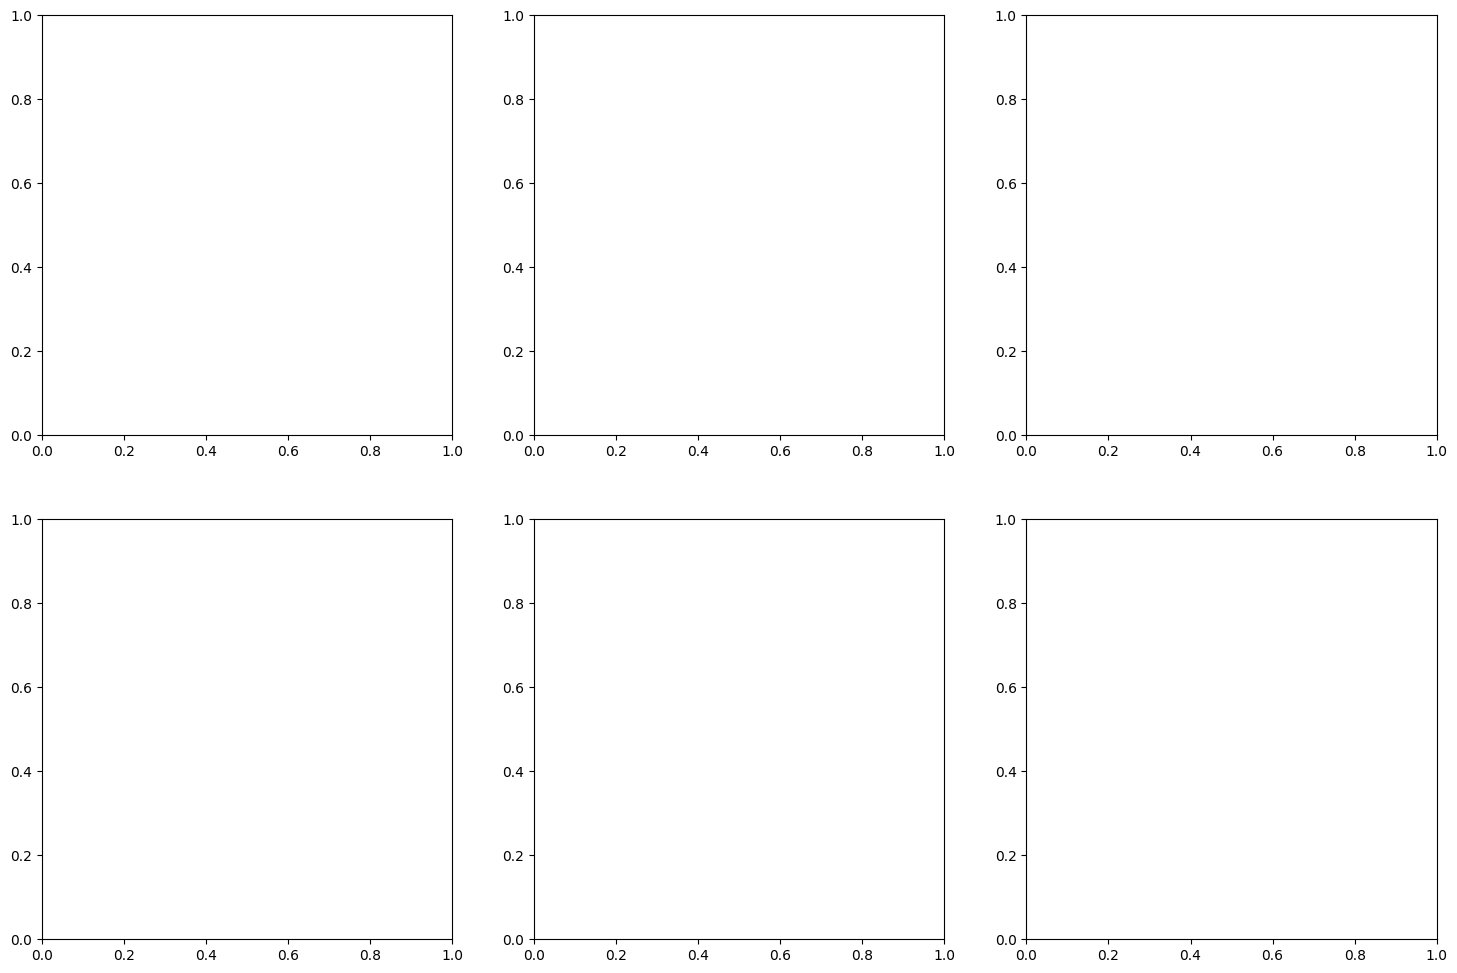

In [32]:
# Get the learned embeddings and attention weights
with torch.no_grad():
    # Get embeddings
    disease_embeddings = model.disease_embeddings.weight.numpy()
    signature_embeddings = model.signature_embeddings.weight.numpy()
    
    # Get learned psi from embeddings
    learned_psi = model.compute_psi().numpy()
    
    # Get attention weights
    E_d = model.disease_embeddings(torch.arange(model.D))
    E_k = model.signature_embeddings(torch.arange(model.K_total))
    attention_scores = torch.matmul(
        torch.matmul(E_d, model.attention_matrix),
        E_k.T
    ) / np.sqrt(model.embedding_dim)
    attention_weights = torch.softmax(attention_scores, dim=1).numpy()

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Disease embeddings (t-SNE)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
disease_2d = tsne.fit_transform(disease_embeddings)

scatter = axes[0, 0].scatter(disease_2d[:, 0], disease_2d[:, 1], 
                            c=range(model.D), cmap='tab10', s=100, alpha=0.7)
axes[0, 0].set_title('Disease Embeddings (t-SNE)')
axes[0, 0].set_xlabel('t-SNE 1')
axes[0, 0].set_ylabel('t-SNE 2')

# Add disease labels
for i in range(model.D):
    axes[0, 0].annotate(f'D{i}', (disease_2d[i, 0], disease_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2. Signature embeddings
signature_2d = tsne.fit_transform(signature_embeddings)
axes[0, 1].scatter(signature_2d[:, 0], signature_2d[:, 1], 
                  c=range(model.K_total), cmap='Set1', s=200, alpha=0.7)
axes[0, 1].set_title('Signature Embeddings (t-SNE)')
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')

# Add signature labels
sig_labels = [f'Sig{i}' for i in range(model.K)] + ['Healthy']
for i, label in enumerate(sig_labels):
    axes[0, 1].annotate(label, (signature_2d[i, 0], signature_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=10)

# 3. Attention weights heatmap
im = axes[0, 2].imshow(attention_weights, cmap='Blues', aspect='auto')
axes[0, 2].set_title('Attention Weights (Diseases × Signatures)')
axes[0, 2].set_xlabel('Signature')
axes[0, 2].set_ylabel('Disease')
plt.colorbar(im, ax=axes[0, 2])

# 4. Learned vs True Psi comparison
true_psi = data['psi']
axes[1, 0].scatter(true_psi.flatten(), learned_psi.flatten(), alpha=0.6)
axes[1, 0].plot([true_psi.min(), true_psi.max()], [true_psi.min(), true_psi.max()], 'r--')
axes[1, 0].set_title('Learned vs True Psi')
axes[1, 0].set_xlabel('True Psi')
axes[1, 0].set_ylabel('Learned Psi')

# 5. Attention weights for top diseases
top_diseases = np.argsort(attention_weights.max(axis=1))[-10:]
axes[1, 1].bar(range(len(top_diseases)), attention_weights[top_diseases].max(axis=1))
axes[1, 1].set_title('Max Attention Weights (Top 10 Diseases)')
axes[1, 1].set_xlabel('Disease Rank')
axes[1, 1].set_ylabel('Max Attention Weight')

# 6. Embedding norms
disease_norms = np.linalg.norm(disease_embeddings, axis=1)
signature_norms = np.linalg.norm(signature_embeddings, axis=1)

axes[1, 2].bar(range(len(disease_norms)), disease_norms, alpha=0.7, label='Diseases')
axes[1, 2].bar(range(len(signature_norms)), signature_norms, alpha=0.7, label='Signatures')
axes[1, 2].set_title('Embedding Norms')
axes[1, 2].set_xlabel('Index')
axes[1, 2].set_ylabel('L2 Norm')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Print some statistics
print("�� Embedding Analysis:")
print(f"   - Disease embedding norm: {disease_norms.mean():.3f} ± {disease_norms.std():.3f}")
print(f"   - Signature embedding norm: {signature_norms.mean():.3f} ± {signature_norms.std():.3f}")
print(f"   - Psi correlation: {np.corrcoef(true_psi.flatten(), learned_psi.flatten())[0, 1]:.3f}")

# Find most attended diseases for each signature
print("\n🎯 Top Diseases per Signature:")
for k in range(model.K_total):
    top_diseases = np.argsort(attention_weights[:, k])[-3:]
    sig_name = f"Signature {k}" if k < model.K else "Healthy"
    print(f"   {sig_name}: Diseases {top_diseases} (attention: {attention_weights[top_diseases, k]})")

In [ ]:
model_est = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=0,                     # Disable GP prior for speed
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True
)

model_est.visualize_initialization()


In [ ]:
from analyze_clusters import *
plot_confusion_matrix(data['clusters'], model_est.clusters, K=5) 

In [ ]:
from clust_huge_amp import *

In [ ]:
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=0,                     # Disable GP prior for speed
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True
)

model.visualize_initialization()


In [ ]:

# Initialize with true psi
model.initialize_params(true_psi=true_psi)
model.clusters = data['clusters'] 

model.visualize_initialization()

In [ ]:

K=5
# Store initial psi values
initial_psi = model.psi.detach().clone()

import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model.fit(E_tensor, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

In [ ]:
history_new[0]
    

In [ ]:
model.kappa

In [ ]:
def plot_training_evolution(history_tuple):
    losses, gradient_history = history_tuple
    
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    #plt.yscale('log')
    plt.legend()
    
    # Plot lambda gradients
    plt.subplot(1, 3, 2)
    lambda_norms = [torch.norm(g).item() for g in gradient_history['lambda_grad']]
    plt.plot(lambda_norms, label='Lambda gradients')
    #plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Lambda Gradient Evolution')
    plt.legend()
    
    # Plot phi gradients
    plt.subplot(1, 3, 3)
    phi_norms = [torch.norm(g).item() for g in gradient_history['phi_grad']]
    plt.plot(phi_norms, label='Phi gradients')
    #plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Phi Gradient Evolution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_evolution(history_new)

In [ ]:
lambda_nans = [torch.isnan(g).any().item() for g in history_new[1]['lambda_grad']]
phi_nans = [torch.isnan(g).any().item() for g in history_new[1]['phi_grad']]

In [ ]:
initial_psi


In [ ]:
model.psi

In [ ]:
model.kappa

In [ ]:
# For plotting smoothed prevalences
def plot_smoothed_prevalences(model, data):
    # Data smoothed prevalence
    data_prev = data['Y'].mean(axis=0)  # Average across individuals
    
    # Model smoothed prevalence (using mu_d/logit_prev_t)
    model_prev = torch.sigmoid(model.logit_prev_t)  # Convert logits to probabilities
    
    plt.figure(figsize=(10, 6))
    
    # Plot for each disease
    for d in range(data_prev.shape[0]):
        plt.plot(data_prev[d], 'b-', alpha=0.3, label='Data' if d==0 else '')
        plt.plot(model_prev[:, d].detach().numpy(), 'r--', alpha=0.3, 
                label='Model' if d==0 else '')
    
    plt.xlabel('Time')
    plt.ylabel('Prevalence')
    plt.title('Smoothed Prevalences: Data vs Model')
    plt.legend()
    plt.yscale('log')  # Optional: use log scale if prevalences vary widely
    plt.grid(True)
    plt.show()

In [ ]:
with torch.no_grad():
    pi_pred, theta, phi = model.forward()
    pi_pred = pi_pred.cpu().numpy()

In [ ]:
model.visualize_initialization()

In [ ]:
# For plotting smoothed prevalences
def plot_smoothed_prevalences(model, data):
    # Data smoothed prevalence
    data_prev = compute_smoothed_prevalence(data['Y'])  # Average across individuals
    
    # Model smoothed prevalence (using mu_d/logit_prev_t)
    model_prev = torch.sigmoid(model.logit_prev_t)  # Convert logits to probabilities
    
    plt.figure(figsize=(10, 6))
    
    # Plot for each disease
    for d in range(data_prev.shape[0]):
        plt.plot(data_prev[d], 'b-', alpha=0.3, label='Data' if d==0 else '')
        plt.plot(model_prev[d, :].detach().numpy(), 'r--', alpha=0.3, 
                label='Model' if d==0 else '')
    
    plt.xlabel('Time')
    plt.ylabel('Prevalence')
    plt.title('Smoothed Prevalences: Data vs Model')
    plt.legend()
    plt.yscale('log')  # Optional: use log scale if prevalences vary widely
    plt.grid(True)
    plt.show()

plot_smoothed_prevalences(model, data)

In [ ]:
# Mean predicted probability for disease 3 over time
mean_pred_d3 = pi_pred[:, 3, :].mean(axis=0)  # Average across people

# Actual prevalence for disease 3 over time
real_prev_pi = data['pi'][:, 3, :].mean(axis=0)  # Average across people

#real_prev_d3 = data['Y'][:, 3, :].mean(axis=0)  # Average across people

real_prev_d3 = model.prevalence_t[3,:]  # Average across people

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(mean_pred_d3, label='Model Predicted average pi for disease 3')
plt.plot(real_prev_pi, label='Actual Average Pi for disease 3 ')
plt.plot(real_prev_d3, label='Actual Incidence for disease 3')
plt.title('Disease 3: Predicted vs Actual Prevalence')
plt.legend()
plt.show()

In [ ]:
# Mean predicted probability for disease 3 over time
mean_pred_d3 = pi_pred[1, 3, :]  # Average across people

# Actual prevalence for disease 3 over time
real_prev_pi = data['pi'][1,3, :]  # Average across people

#real_prev_d3 = data['Y'][:, 3, :].mean(axis=0)  # Average across people

#real_prev_d3 = model.prevalence_t[3,:]  # Average across people

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(mean_pred_d3, label='Model Predicted person 1 pi for disease 3')
plt.plot(real_prev_pi, label='Actual person 1  for disease 3 ')
#plt.plot(real_prev_d3, label='Actual Incidence for disease 3')
plt.title('Disease 3: Predicted vs Actual Prevalence')
plt.legend()
plt.show()

In [ ]:
# Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model.prevalence_t.mean(axis=0)  # Average across diseases
real_pi_all = data['pi'].mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [ ]:
model.kappa

In [ ]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()
#observed_risk=mu_dt_flat
# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor
print(scale_factor)
print(np.mean(observed_risk))
print(np.mean(predicted_risk)) 
print(np.mean(calibrated_risk))

In [ ]:
calibrated_risk.shape

In [ ]:
scale_factor

In [ ]:
# Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))
#mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model.prevalence_t.mean(axis=0)  # Average across diseases
#real_pi_all = calibrated_risk.mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [ ]:

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [ ]:
def plot_hazard_comparison(Y, pi_pred, true_pi, calibration_factor):
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Apply calibration to predictions
    calibrated_pred = pi_pred * calibration_factor
    
    # Calculate means for at-risk only
    mean_pred = []
    mean_true = []
    mean_obs = []
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            mean_pred.append(calibrated_pred[:,:,t][mask_t].mean())
            mean_true.append(true_pi[:,:,t][mask_t].mean())
            mean_obs.append(Y[:,:,t][mask_t].mean())
    
    plt.figure(figsize=(12,8))
    plt.plot(mean_pred, 'b-', label='Calibrated Model Prediction')
    plt.plot(mean_true, 'g--', label='True Hazard')
    plt.plot(mean_obs, 'r.', label='Observed Events')
    plt.title('Hazard Rates (At-Risk Individuals)')
    plt.xlabel('Time')
    plt.ylabel('Hazard')
    plt.legend()
    plt.show()

In [ ]:
def calculate_calibration_factor(Y, pi_pred, true_pi):
    """
    Calculate calibration factor comparing predictions to true hazards
    Only using at-risk times
    """
    # Create at_risk mask
    N, D, T = Y.shape
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Get valid predictions and true values
    valid_pred = pi_pred[at_risk]
    valid_true = true_pi[at_risk]
    
    # Calculate calibration factor
    calibration_factor = valid_true.mean() / valid_pred.mean()
    
    print(f"Mean predicted: {valid_pred.mean():.6f}")
    print(f"Mean true: {valid_true.mean():.6f}")
    print(f"Calibration factor: {calibration_factor:.4f}")
    
    return calibration_factor

In [ ]:
calculate_calibration_factor(Y, pi_pred, data['pi'])

In [ ]:
plot_hazard_comparison(data['Y'], pi_pred, data['pi'],1)

In [ ]:
def calculate_fair_calibration_factor(Y, pi_pred):
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Calculate ratio of observed events to predictions for at-risk individuals
    total_observed = 0
    total_predicted = 0
    
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            total_observed += Y[:,:,t][mask_t].sum()
            total_predicted += pi_pred[:,:,t][mask_t].sum()
    
    return total_observed / total_predicted if total_predicted > 0 else 1.0

cf=calculate_fair_calibration_factor(Y, pi_pred)

In [ ]:
cf

In [ ]:
# Calibration plot
from clust_huge_amp_w_warp import plot_calibration_at_risk
plot_calibration_at_risk(pi_pred, data['Y'],use_log_scale=True)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_true_calibration(pi_pred, true_pi, Y, n_bins=20, use_log_scale=False, min_bin_count=50):
    """
    Plots calibration curve: predicted pi vs. true pi (ground truth), at at-risk times.
    """
    # Ensure numpy arrays
    if hasattr(pi_pred, 'detach'):
        pi_pred = pi_pred.detach().cpu().numpy()
    if hasattr(true_pi, 'detach'):
        true_pi = true_pi.detach().cpu().numpy()
    if hasattr(Y, 'detach'):
        Y = Y.detach().cpu().numpy()
    N, D, T = Y.shape

    # At-risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n, d, :])[0]
            if len(event_times) > 0:
                at_risk[n, d, (event_times[0]+1):] = False

    pred = pi_pred[at_risk]
    truth = true_pi[at_risk]

    # Bin by predicted probability
    if use_log_scale:
        bin_edges = np.logspace(np.log10(max(1e-7, pred.min())), np.log10(pred.max()), n_bins + 1)
    else:
        bin_edges = np.linspace(pred.min(), pred.max(), n_bins + 1)

    bin_means = []
    truth_means = []
    counts = []

    for i in range(n_bins):
        mask = (pred >= bin_edges[i]) & (pred < bin_edges[i + 1])
        if np.sum(mask) >= min_bin_count:
            bin_means.append(np.mean(pred[mask]))
            truth_means.append(np.mean(truth[mask]))
            counts.append(np.sum(mask))

    # Plot
    plt.figure(figsize=(7, 7))
    if use_log_scale:
        plt.xscale('log')
        plt.yscale('log')
        plt.plot([1e-7, 1], [1e-7, 1], '--', color='gray', label='Perfect calibration')
    else:
        plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect calibration')

    plt.plot(bin_means, truth_means, 'o-', label='True risk')
    plt.xlabel('Predicted Event Rate')
    plt.ylabel('True Event Rate')
    plt.title('Calibration to Ground Truth (At-Risk Only)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.show()

    # Print summary stats
    mse = np.mean((np.array(bin_means) - np.array(truth_means))**2)
    print(f'MSE: {mse:.2e}')
    print(f'Mean Predicted: {np.mean(pred):.2e}')
    print(f'Mean True: {np.mean(truth):.2e}')
    print(f'N total: {len(pred):,}')

    return bin_means, truth_means, counts

# Example usage:
plot_true_calibration(pi_pred, data['pi'], data['Y'], n_bins=20, use_log_scale=True)